In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageEnhance, ImageOps
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from keras._tf_keras.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)
        
    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),  # Changed back to 64 channels
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, padding=1),  # Changed back to 128 channels
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        self.residual_blocks = nn.Sequential(
            ResidualBlock(128),  # Changed back to 128 channels
            ResidualBlock(128),
            ResidualBlock(128)   # Added back the third residual block
        )
        
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128, 64, 3, padding=1),  # Changed to match checkpoint
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),   # Changed to match checkpoint
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, 3, padding=1),    # Changed to match checkpoint
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.residual_blocks(x)
        x = self.decoder(x)
        return x

In [5]:
class EnhancedDRDataset(Dataset):
    def __init__(self, df, base_image_dir, label_mapping, generator_model, device, img_size=(224, 224)):
        self.df = df
        self.base_image_dir = base_image_dir
        self.label_mapping = label_mapping
        self.img_size = img_size
        self.generator = generator_model
        self.device = device
        
        self.transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
        
    def enhance_image(self, image):
        # Convert to PIL Image if it's not already
        if not isinstance(image, Image.Image):
            image = Image.fromarray(image)
            
        # Apply GAN enhancement
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            enhanced = self.generator(img_tensor)
        
        # Convert back to image
        enhanced = enhanced.squeeze(0).cpu()
        enhanced = enhanced * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + \
                  torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        enhanced = enhanced.clamp(0, 1)
        enhanced = transforms.ToPILImage()(enhanced)
        
        # Adjust enhancement parameters
        enhanced = ImageEnhance.Brightness(enhanced).enhance(1.1)  # Reduced enhancement
        enhanced = ImageEnhance.Contrast(enhanced).enhance(1.6)     # Reduced enhancement
        enhanced = ImageEnhance.Sharpness(enhanced).enhance(1.7)    # Reduced enhancement

        return enhanced
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        label = row['diagnosis']
        
        # Find the image in the appropriate directory
        for label_name, label_num in self.label_mapping.items():
            img_dir = os.path.join(self.base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                # Load and enhance the image
                image = Image.open(img_path).convert('RGB')
                enhanced_image = self.enhance_image(image)
                
                # Convert to numpy array and normalize
                enhanced_array = np.array(enhanced_image)
                enhanced_array = enhanced_array / 255.0
                
                return enhanced_array, label
                
        raise FileNotFoundError(f"Image not found for id_code: {row['id_code']}")

In [6]:
def preprocess_data_with_gan(df, base_image_dir, label_mapping, generator_model, device, img_size=(224, 224)):
    images = []
    labels = []
    
    # Create an instance of EnhancedDRDataset for image enhancement
    dataset = EnhancedDRDataset(df, base_image_dir, label_mapping, generator_model, device)
    
    for index, row in df.iterrows():
        for label_name, label_num in label_mapping.items():
            img_dir = os.path.join(base_image_dir, label_name)
            img_path = os.path.join(img_dir, row['id_code'] + '.png')
            if os.path.exists(img_path):
                # Get enhanced image using GAN
                image, _ = dataset[index]
                
                # Convert to cv2 format and resize
                image = (image * 255).astype(np.uint8)
                image = cv2.resize(image, img_size)
                
                images.append(image)
                labels.append(label_num)

    images = np.array(images)
    labels = np.array(labels)
    labels = to_categorical(labels, num_classes=5)

    return images, labels

In [7]:
from keras._tf_keras.keras.models import Sequential, Model
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras._tf_keras.keras.layers import (
    Conv2D, 
    MaxPooling2D, 
    Dense, 
    Flatten, 
    Dropout,
    BatchNormalization
)
from keras._tf_keras.keras.models import Sequential

def create_cnn_model(input_shape=(224, 224, 3)):
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        
        # Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ])
    
    return model

In [8]:
import tensorflow as tf
def train_combined_models(df, base_image_dir, label_mapping, gan_model_path='enhanced_gan_models.pth'):
    # Set up device for GAN
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load and initialize the GAN generator
    generator = Generator().to(device)
    checkpoint = torch.load(gan_model_path, map_location=device)
    generator.load_state_dict(checkpoint['model_state_dict'])
    generator.eval()
    
    # Preprocess data with GAN enhancement
    print("Preprocessing data with GAN enhancement...")
    images, labels = preprocess_data_with_gan(df, base_image_dir, label_mapping, generator, device)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)
    
    # Create and compile CNN model
    cnn_model = create_cnn_model()
    cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Lower learning rate
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Add data augmentation
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomFlip("horizontal")
    ])
    
    # Train with more epochs and adjusted batch size
    history = cnn_model.fit(
        data_augmentation(X_train), y_train,
        validation_data=(X_val, y_val),
        epochs=10,  # Increased epochs
        # batch_size=32,  # Adjusted batch size
    )
    
    return cnn_model, history

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [10]:
# Load your data
data_path = 'FGADR/train.csv'
df = pd.read_csv(data_path)
base_image_dir = 'FGADR'

# Define label mapping
label_mapping = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4
}

In [13]:

# Train the models
cnn_model, history = train_combined_models(
    df=df,
    base_image_dir=base_image_dir,
    label_mapping=label_mapping,
    gan_model_path='enhanced_gan_models.pth'
)

Preprocessing data with GAN enhancement...


c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 184s 2s/step - accuracy: 0.3536 - loss: 1.9339 - val_accuracy: 0.6385 - val_loss: 1.4845
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.5362 - loss: 1.3354 - val_accuracy: 0.6739 - val_loss: 1.3858
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.5573 - loss: 1.2449 - val_accuracy: 0.5375 - val_loss: 1.6564
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.5976 - loss: 1.1237 - val_accuracy: 0.6971 - val_loss: 0.9224
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.6602 - loss: 0.9905 - val_accuracy: 0.4379 - val_loss: 1.5341
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.6728 - loss: 0.9235 - val_accuracy: 0.6398 - val_loss: 0.9291
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 163s 2s/step - accuracy: 0.6949 - loss: 0.8783 - val_accuracy: 0.5812 - val_loss: 1.2774
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.6685 - loss: 0.9136 - val_accuracy: 0.7231 - v

HYPERPERPARAMETER TUNNING

c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.5079 - loss: 41.5210 - val_accuracy: 0.6971 - val_loss: 0.8611
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.6879 - loss: 0.8583 - val_accuracy: 0.7108 - val_loss: 0.8892
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.6742 - loss: 0.8991 - val_accuracy: 0.7176 - val_loss: 0.8341
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.7189 - loss: 0.7812 - val_accuracy: 0.7108 - val_loss: 0.7770
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 213s 2s/step - accuracy: 0.7204 - loss: 0.7540 - val_accuracy: 0.7258 - val_loss: 0.7757
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.7452 - loss: 0.7182 - val_accuracy: 0.7217 - val_loss: 0.7866
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.7412 - loss: 0.6773 - val_accuracy: 0.7312 - val_loss: 0.7629
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.7637 - loss: 0.6319 - val_accuracy: 0.7394 - 

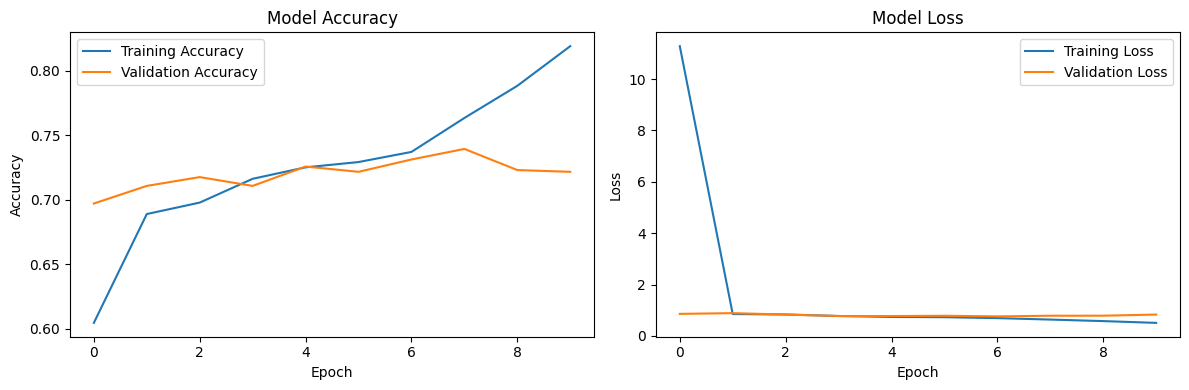

In [10]:
# Example: Modify learning rate and optimizer
import torch
from keras._tf_keras.keras.optimizers import Adam

# Set up device for GAN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and initialize the GAN generator
generator = Generator().to(device)
checkpoint = torch.load('enhanced_gan_models.pth', map_location=device)
generator.load_state_dict(checkpoint['model_state_dict'])
generator.eval()
# Create a new CNN model
cnn_model_tuned = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile with different learning rate and optimizer
cnn_model_tuned.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Get the preprocessed data using your existing function
images, labels = preprocess_data_with_gan(
    df=df,
    base_image_dir=base_image_dir,
    label_mapping=label_mapping,
    generator_model=generator,
    device=device
)

# Split the data
X_train_tuned, X_val_tuned, y_train_tuned, y_val_tuned = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

# Train the tuned CNN model
history_tuned = cnn_model_tuned.fit(
    X_train_tuned, 
    y_train_tuned, 
    epochs=10, 
    validation_data=(X_val_tuned, y_val_tuned)
)

# Plot the results
plot_training_history(history_tuned)

 **Using Data Augmentation**

In [11]:
# 1. First, set up the GAN generator and device
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and initialize the GAN generator
generator = Generator().to(device)
checkpoint = torch.load('enhanced_gan_models.pth', map_location=device)
generator.load_state_dict(checkpoint['model_state_dict'])
generator.eval()

# 2. Preprocess data using your existing GAN-enhanced preprocessing
images, labels = preprocess_data_with_gan(
    df=df,
    base_image_dir=base_image_dir,
    label_mapping=label_mapping,
    generator_model=generator,
    device=device
)

# 3. Split the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

In [12]:
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator


In [13]:
# Define data augmentation settings
datagen = ImageDataGenerator(
    rotation_range=20,  # Random rotation up to 20 degrees
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.2,  # Random shear
    zoom_range=0.2,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
    vertical_flip=False  # No vertical flip for retinal images
)


c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3270 - loss: 1.9378

91/91 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.3277 - loss: 1.9348 - val_accuracy: 0.4775 - val_loss: 5.7681
Epoch 2/10
 1/91 ━━━━━━━━━━━━━━━━━━━━ 3:52 3s/step - accuracy: 0.6562 - loss: 1.1439

c:\Users\ompat\Downloads\DRD_GAN\venv\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


91/91 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.6562 - loss: 1.1439 - val_accuracy: 0.4775 - val_loss: 5.6209
Epoch 3/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5081 - loss: 1.3796

91/91 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.5084 - loss: 1.3787 - val_accuracy: 0.5675 - val_loss: 1.8142
Epoch 4/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 120ms/step - accuracy: 0.4688 - loss: 1.6252 - val_accuracy: 0.5007 - val_loss: 2.0581
Epoch 5/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.5790 - loss: 1.2092 - val_accuracy: 0.4816 - val_loss: 2.4777
Epoch 6/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.5625 - loss: 1.2895 - val_accuracy: 0.4829 - val_loss: 2.6294
Epoch 7/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5694 - loss: 1.1948

91/91 ━━━━━━━━━━━━━━━━━━━━ 243s 3s/step - accuracy: 0.5695 - loss: 1.1943 - val_accuracy: 0.6726 - val_loss: 1.1064
Epoch 8/10
 1/91 ━━━━━━━━━━━━━━━━━━━━ 4:10 3s/step - accuracy: 0.5625 - loss: 1.1267

91/91 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.5625 - loss: 1.1267 - val_accuracy: 0.6780 - val_loss: 1.1082
Epoch 9/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 234s 3s/step - accuracy: 0.6120 - loss: 1.0888 - val_accuracy: 0.5239 - val_loss: 1.1687
Epoch 10/10
91/91 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.7188 - loss: 0.8699 - val_accuracy: 0.5102 - val_loss: 1.2228


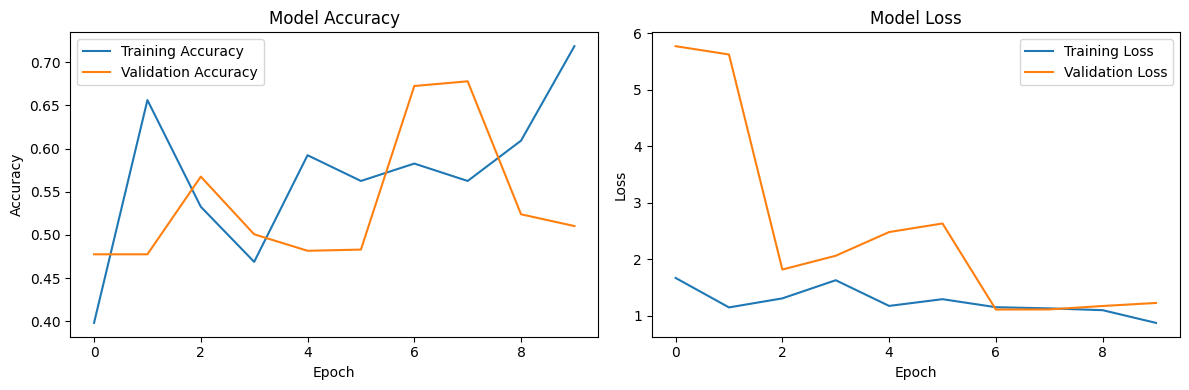

In [14]:
# 1. Import necessary libraries
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras._tf_keras.keras.optimizers import Adam
import tensorflow as tf

# 2. Create the CNN model
cnn_model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    
    # Dense layers
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

# 3. Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Now train the model with augmented data
history = cnn_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model_augmented.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]
)

# 5. Plot the results
plot_training_history(history)

In [33]:
# Create the ANN model
ann_model = Sequential()
ann_model.add(Dense(128, activation='relu', input_shape=(cnn_model.output_shape[1],)))
ann_model.add(Dropout(0.5))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(5, activation='softmax'))  # Assuming 5 classes

# Compile the ANN model
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the ANN model using CNN features
ann_model.fit(cnn_model.predict(X_train), y_train, epochs=10, validation_data=(cnn_model.predict(X_val), y_val))

92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 307ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 300ms/step
Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4845 - loss: 1.3383 - val_accuracy: 0.6958 - val_loss: 0.9524
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6866 - loss: 0.9540 - val_accuracy: 0.6985 - val_loss: 0.9473
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6840 - loss: 0.9394 - val_accuracy: 0.6999 - val_loss: 0.9570
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6938 - loss: 0.9453 - val_accuracy: 0.6985 - val_loss: 0.9443
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6876 - loss: 0.9366 - val_accuracy: 0.6985 - val_loss: 0.9416
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6992 - loss: 0.9242 - val_accuracy: 0.6985 - val_loss: 0.9409
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6763 - loss: 0.9454 - val_accuracy: 0.6985 - val_loss: 0.9417
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━

23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


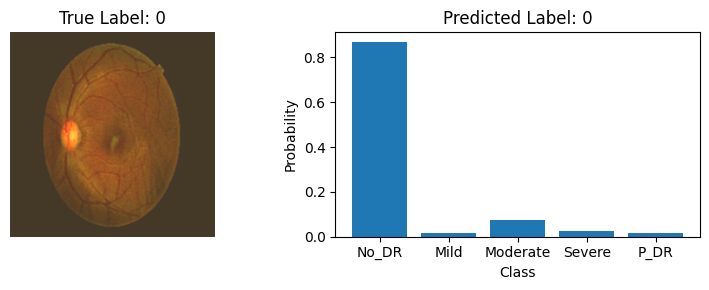

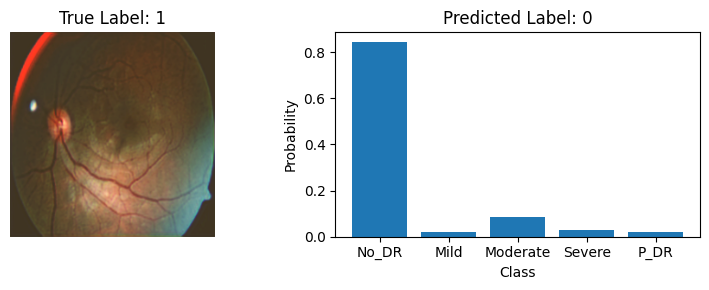

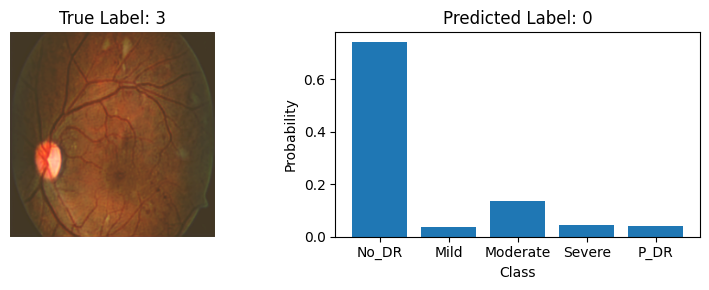

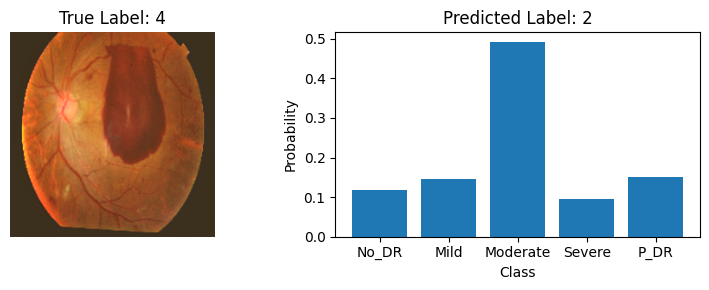

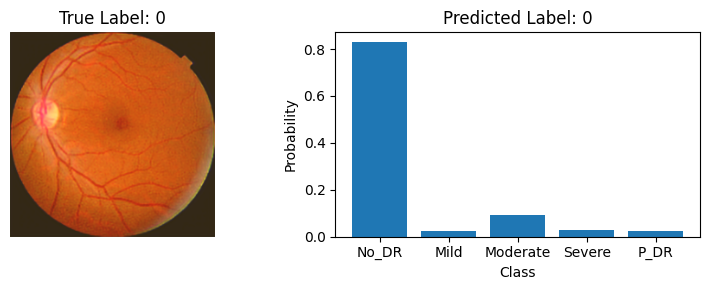

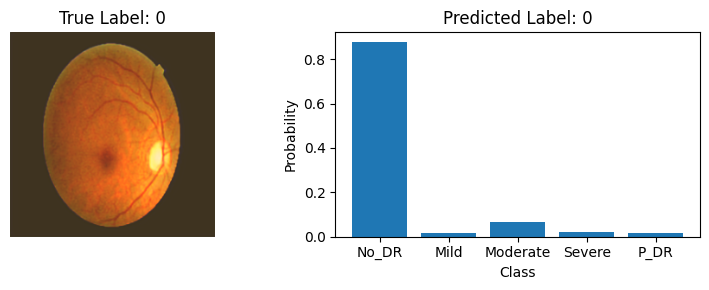

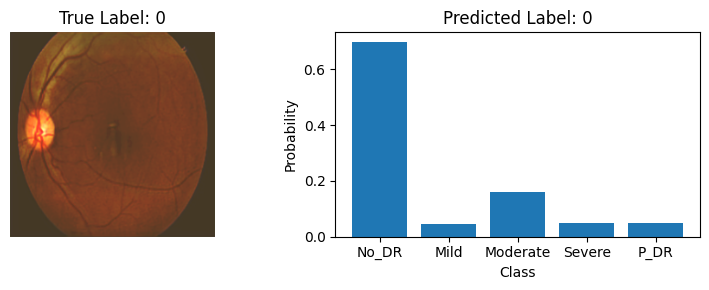

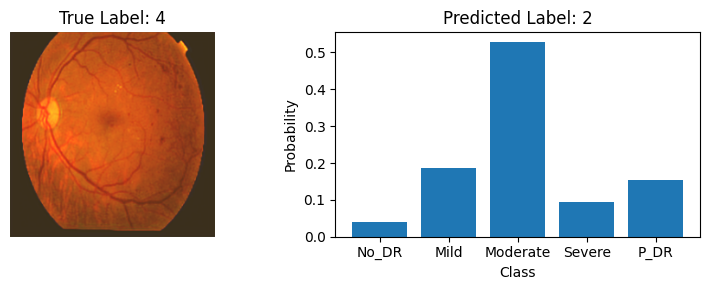

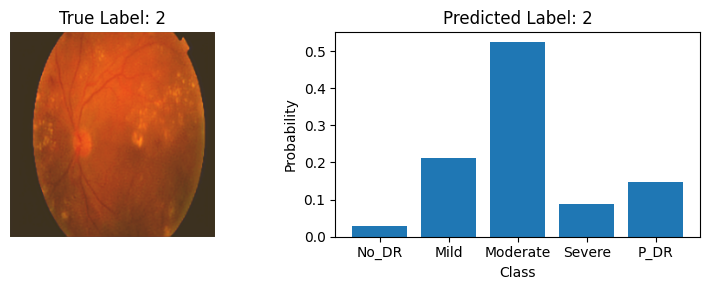

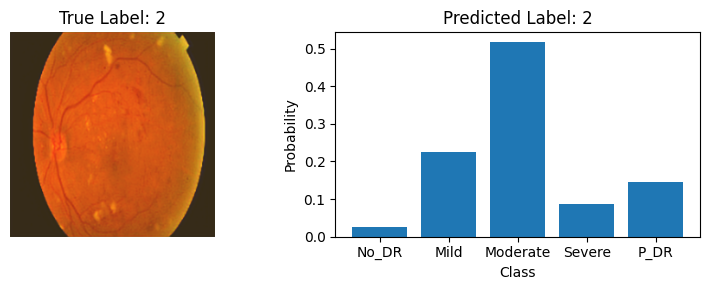

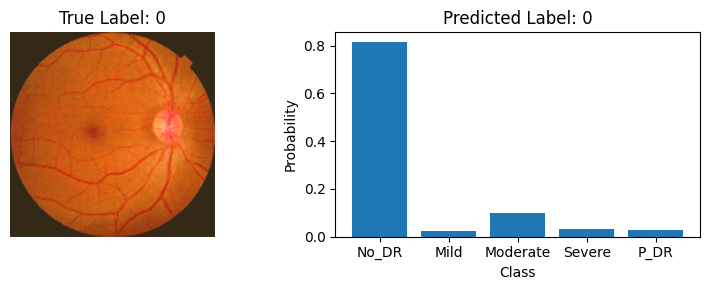

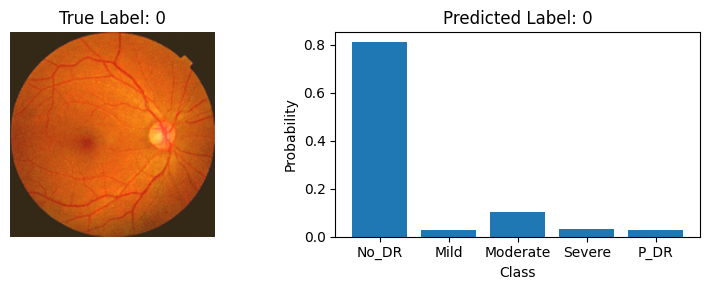

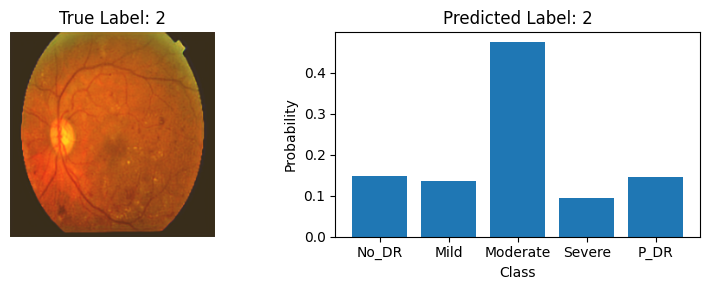

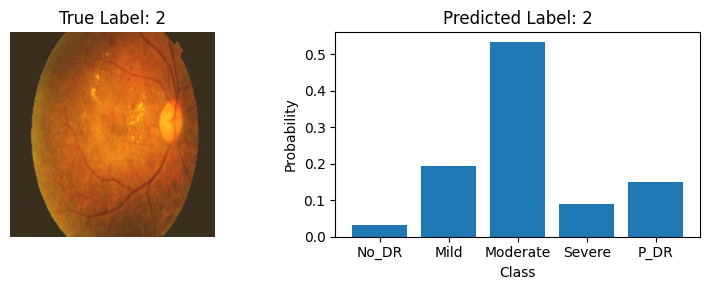

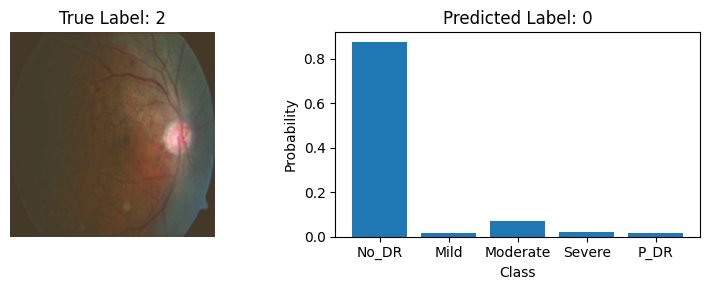

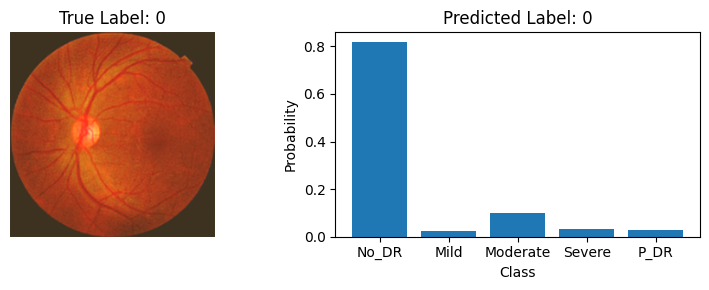

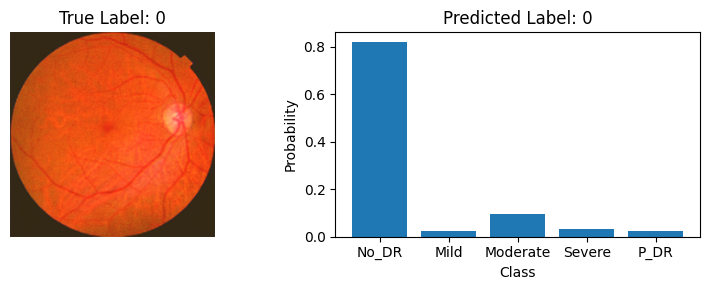

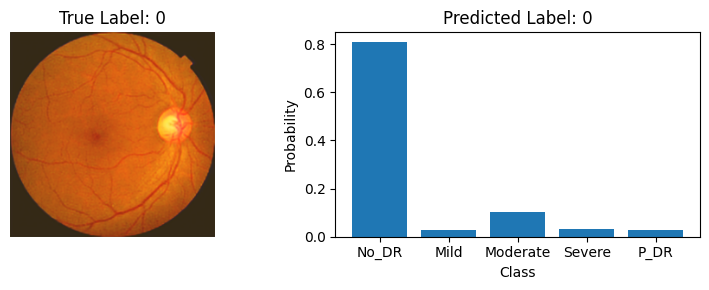

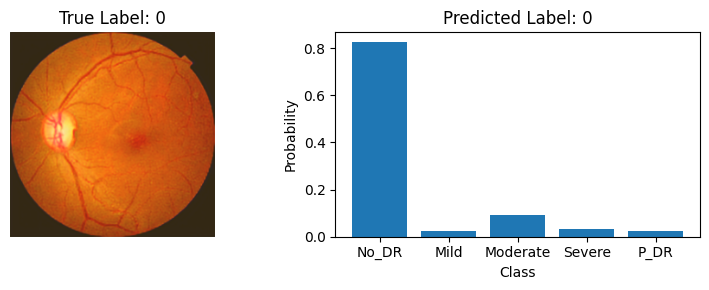

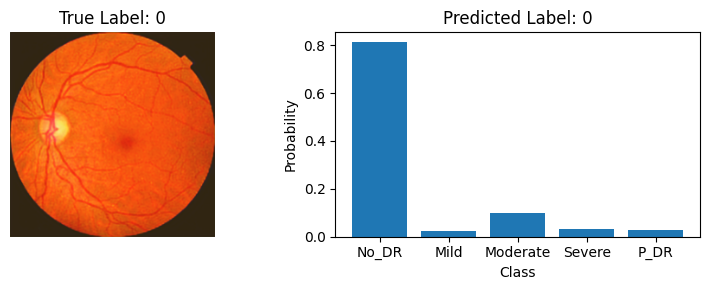

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a trained model (cnn_model and ann_model) already

# Get predictions for test data
cnn_predictions = cnn_model.predict(X_val)
ann_predictions = ann_model.predict(cnn_predictions)

# Convert one-hot encoded labels back to class labels
predicted_classes = np.argmax(ann_predictions, axis=1)

# Visualize a few test images along with their predicted labels
num_samples_to_visualize = 20
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[i])
    plt.title(f"True Label: {np.argmax(y_val[i])}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.bar(range(5), ann_predictions[i])
    plt.xticks(range(5), ['No_DR', 'Mild', 'Moderate', 'Severe', 'P_DR'])
    plt.title(f"Predicted Label: {predicted_classes[i]}")
    plt.xlabel("Class")
    plt.ylabel("Probability")
    plt.tight_layout()

    plt.show()
